In [1]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import matplotlib.pyplot as plt
import numba
from numba import njit
import numpy as np

In [2]:
filename ="/pnfs/psi.ch/cms/trivcat/store/mc/Run3Summer22EENanoAODv12/VBFHHto4B_CV_1_C2V_1_C3_1_TuneCP5_13p6TeV_madgraph-pythia8/NANOAODSIM/130X_mcRun3_2022_realistic_postEE_v6-v3/80000/a897cbbf-ea0b-40d5-b850-f9f24a7906a5.root"
# events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema).events()
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema, entry_stop=20).events()
print("Events read:", len(events))

Events read: 20


In [3]:
events.GenPart=ak.with_field(events.GenPart, ak.local_index(events.GenPart, axis=1), "index")
genpart= events.GenPart
single_event=-1
if (single_event!=-1):
    genpart= events.GenPart[single_event]


isQuark = abs(genpart.pdgId) < 7
isHard = genpart.hasFlags(["fromHardProcess"])

quarks = genpart[isQuark & isHard]
quarks = quarks[quarks.genPartIdxMother!=-1]

quarks_mother = genpart[quarks.genPartIdxMother]
quarks_mother_children = quarks_mother.children
quarks_mother_children_isH = ak.sum((quarks_mother_children.pdgId == 25), axis=-1)==2
vbf_quarks = quarks[quarks_mother_children_isH]


print(quarks_mother_children_isH, quarks_mother_children_isH[0])
print(quarks.pdgId, quarks.genPartIdxMother, quarks.index)
print(vbf_quarks.pdgId, vbf_quarks.genPartIdxMother, vbf_quarks.index, genpart[vbf_quarks.genPartIdxMother].pdgId)
print(vbf_quarks.hasFlags(["isFirstCopy"]))


[[True, True, False, False, False, False, ... False, False, False, False, False]] [True, True, False, False, False, False, ... False, False, False, False, False]
[[2, 2, 5, -5, 5, -5, 5, 5, 2, 2, -5, 5, ... 5, -5, -5, 5, -5, 5, 5, 2, 5, 5, -5, 1]] [[0, 0, 10, 10, 11, 11, 12, 14, 5, 4, 15, ... 24, 21, 21, 26, 23, 4, 29, 28, 27, 5]] [[4, 5, 12, 13, 14, 15, 17, 18, 20, 21, ... 25, 26, 27, 28, 29, 34, 42, 44, 46, 51]]
[[2, 2], [2, 1], [4, 1], [4, 1], [1, -1], ... 2, 1], [4, 1], [4, 1], [2, -4], [2, 1]] [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], ... [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]] [[4, 5], [4, 5], [4, 5], [4, 5], [4, 5], ... [4, 5], [4, 5], [4, 5], [4, 5], [4, 5]] [[2, 2], [1, 1], [2, 2], [2, 2], [-2, -2, ... 1], [3, 3], [2, 2], [-3, -3], [2, 2]]
[[False, False], [False, False], [True, ... True], [True, True], [False, False]]


In [4]:

children_idxG = ak.without_parameters(genpart.childrenIdxG, behavior={})
children_idxG_flat = ak.flatten(children_idxG, axis=1)
genpart_pdgId_flat = ak.flatten(ak.without_parameters(genpart.pdgId, behavior={}), axis=1)
genpart_LastCopy_flat = ak.flatten(ak.without_parameters(genpart.hasFlags(["isLastCopy"]), behavior={}), axis=1)
genpart_pt_flat = ak.flatten(ak.without_parameters(genpart.pt, behavior={}), axis=1)
genparts_flat = ak.flatten(genpart)
genpart_offsets = np.concatenate([[0],np.cumsum(ak.to_numpy(ak.num(genpart, axis=1), allow_missing=True))])
local_index_all = ak.local_index(genpart, axis=1)
local_index_vbf = ak.local_index(vbf_quarks, axis=1)
vbf_quark_idx = ak.to_numpy(vbf_quarks.index+genpart_offsets[:-1], allow_missing=False)
vbf_quarks_pdgId = ak.to_numpy(vbf_quarks.pdgId, allow_missing=False)
nevents=vbf_quark_idx.shape[0]


In [5]:
print(genpart_offsets)
print(children_idxG)
print(children_idxG_flat)
print(genpart_pdgId_flat)
print(genpart_LastCopy_flat)
print(genparts_flat.index, ak.num(genparts_flat.index, axis=0))
print(local_index_all, ak.num(local_index_all, axis=1))
print(nevents)
print(vbf_quark_idx)

[   0   53  108  168  219  275  329  378  437  506  553  618  690  736
  795  858  902  944 1015 1109 1198]
[[[2, 3, 4, 5], [], [6], [7], [21], ... [1195], [], [], [1196, 1197], [], [], []]]
[[2, 3, 4, 5], [], [6], [7], [21], ... [1195], [], [], [1196, 1197], [], [], []]
[2, 2, 25, 25, 2, 2, 25, 25, 25, 25, ... 421, 431, 111, -11, 12, 221, 22, 22, 22]
[False, False, False, False, False, False, ... True, True, True, True, True, True]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ... 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88] 1198
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ... 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88]] [53, 55, 60, 51, 56, 54, 49, 59, 69, 47, 65, 72, 46, 59, 63, 44, 42, 71, 94, 89]
20
[[   4    5]
 [  57   58]
 [ 112  113]
 [ 172  173]
 [ 223  224]
 [ 279  280]
 [ 333  334]
 [ 382  383]
 [ 441  442]
 [ 510  511]
 [ 557  558]
 [ 622  623]
 [ 694  695]
 [ 740  741]
 [ 799  800]
 [ 862  863]
 [ 906  907]
 [ 948  949]
 [1019 1020]
 [1113 1114]]


In [6]:
@njit
def analyze_parton_from_vbf_quarks(
    vbf_quarks_idx,
    vbf_quarks_pdgId,
    children_idxG_flat,
    genpart_pdgId_flat,
    genpart_offsets,
    genpart_LastCopy_flat,
    genpart_pt_flat,
    nevents,
):
    prints=False
    # print input array
    if prints:
        print("vbf_quarks_idx", vbf_quarks_idx)
        print("vbf_quarks_pdgId", vbf_quarks_pdgId)
        print("children_idxG_flat", children_idxG_flat)
        print("genpart_pdgId_flat", genpart_pdgId_flat)
        print("genpart_offsets", genpart_offsets)
        print("genpart_LastCopy_flat", genpart_LastCopy_flat)
        print("nevents", nevents)

    # get the children ofthe vbf_quarks which have the same pdgId of the mother iteratively until we reach the last copy

    out = np.zeros(vbf_quarks_idx.shape, dtype="int64")-1

    for iev in range(vbf_quarks_idx.shape[0]):
        if prints: print("Event", iev)
        for ipart in range(vbf_quarks_idx.shape[1]):
            p_id = vbf_quarks_idx[iev][ipart]
            if prints: print("Parton", ipart)
            i=0
            while not genpart_LastCopy_flat[p_id] and i<5:
                i+=1
                children_idxs = children_idxG_flat[p_id]
                if prints: print(children_idxs)

                #get the children with the same pdgId as the mother with highest pt
                max_pt = -1
                max_pt_idx = -1
                if genpart_LastCopy_flat[p_id]:
                    out[iev][ipart] = p_id
                    continue


                # num_pdg_equal=0
                # for child_idx in children_idxs:
                #     if genpart_pdgId_flat[child_idx] == vbf_quarks_pdgId[iev][ipart]:
                #         num_pdg_equal+=1
                # if num_pdg_equal==1:
                #     p_id = children_idxs[0]
                #     break
                # if prints: print("\n\n###################\n\n")


                for child_idx in children_idxs:
                    if prints: print("Child", child_idx)
                    if prints: print(vbf_quarks_pdgId[iev][ipart])
                    if prints: print(genpart_pdgId_flat[child_idx])
                    if genpart_pdgId_flat[child_idx] != vbf_quarks_pdgId[iev][ipart]:
                        continue
                    child_pt = genpart_pt_flat[child_idx]
                    if prints: print(child_pt)
                    if child_pt > max_pt:
                        max_pt_idx = child_idx
                        max_pt = child_pt

                if prints: print("genpart_LastCopy_flat", genpart_LastCopy_flat[max_pt_idx])
                if  genpart_LastCopy_flat[max_pt_idx]:
                    if prints: print("Found child")
                    out[iev][ipart] = max_pt_idx
                if prints: print(p_id, max_pt_idx)
                p_id = max_pt_idx
                if prints: print(p_id, max_pt_idx)
                # break
                # if max_pt == -1:
                #     max_pt_idx = p_id
                if out[iev][ipart]!=-1:
                    if prints: print("out", out[iev][ipart])
                    break

    return out

In [7]:
vbf_quark_last_idx=analyze_parton_from_vbf_quarks(
    vbf_quark_idx,
    vbf_quarks_pdgId,
    children_idxG_flat,
    genpart_pdgId_flat,
    genpart_offsets,
    genpart_LastCopy_flat,
    genpart_pt_flat,
    nevents,
)
print(vbf_quark_last_idx)
print(genpart_offsets[:-1])

[[  21   20]
 [  82   75]
 [ 131  141]
 [ 187  192]
 [ 252  241]
 [ 308  294]
 [ 343  344]
 [ 396  413]
 [ 454  473]
 [ 522  523]
 [ 574  583]
 [ 649  656]
 [ 719  709]
 [ 755  772]
 [ 814  832]
 [ 876  879]
 [ 924  930]
 [ 985  966]
 [1039 1067]
 [1143 1160]]
[   0   53  108  168  219  275  329  378  437  506  553  618  690  736
  795  858  902  944 1015 1109]


# Do some tests

In [21]:
print(len(genparts_flat[vbf_quark_last_idx]), genparts_flat[vbf_quark_last_idx])

vbf_quark_last=genparts_flat[vbf_quark_last_idx]
print(vbf_quark_last.pdgId, vbf_quark_last.pt, vbf_quark_last.eta, vbf_quark_last.phi)



20 [[GenParticle, GenParticle], [GenParticle, ... [GenParticle, GenParticle]]
[[2, 2], [2, 1], [4, 1], [4, 1], [1, -1], ... 2, 1], [4, 1], [4, 1], [2, -4], [2, 1]] [[103, 34], [8.03, 15.3], [34.5, 27.2], ... [15.2, 3.75], [13.9, 116], [41.4, 26.1]] [[-3.42, 3.9], [3.49, -3.48], [-2.8, 4.11, ... 1.15], [-2.12, 1.63], [-0.0389, 3.94]] [[-2.97, -1.8], [1.86, -0.403], [2.91, -0.491, ... 1.5], [-0.838, 1.84], [2.51, 1.4]]
[[[2, 2], [2, 1]], [[4, 1], [4, 1]], ... [[4, 1], [4, 1]], [[2, -4], [2, 1]]] [[[103, 34], [8.03, 15.3]], [[34.5, 27.2, ... 3.75]], [[13.9, 116], [41.4, 26.1]]] [[[-3.42, 3.9], [3.49, -3.48]], [[-2.8, ... 1.15]], [[-2.12, 1.63], [-0.0389, 3.94]]] [[[-2.97, -1.8], [1.86, -0.403]], [[2.91, ... 1.5]], [[-0.838, 1.84], [2.51, 1.4]]]


[103, 34, 8.03, 15.3, 34.5, 27.2, 3.92, ... 47.6, 15.2, 3.75, 13.9, 116, 41.4, 26.1]


(array([0., 0., 2., 1., 0., 1., 0., 2., 0., 0., 1., 1., 2., 1., 1., 0., 1.,
        0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 2., 2.,
        0., 2., 2., 0., 0., 0., 0., 0., 2., 1., 1., 1., 1., 1., 0., 2., 2.,
        0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.        , 0.02      , 0.04      , 0.06      , 0.08      ,
        0.1       , 0.12      , 0.14      , 0.16      , 0.18000001,
        0.2       , 0.22      , 0.23999999, 0.25999999, 0.28      ,
        0.30000001, 0.31999999, 0.34      , 0.36000001, 0.38      ,
        0.40000001, 0.41999999, 0.44      , 0.46000001, 0.47999999,
        0.5       , 0.51999998, 0.54000002, 0.56      , 0.57999998,
        0.60000002, 0.62      , 0.63999999, 0.66000003, 0.68000001,
        0.69999999, 0.72000003, 0.74000001, 0.75999999, 0.77999997,
      

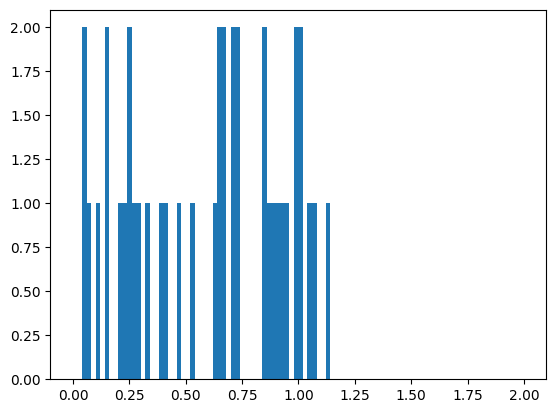

In [9]:
vbf_quark_last_pt=ak.flatten(genparts_flat[vbf_quark_last_idx].pt)
vbf_quark_first_pt=ak.flatten(genparts_flat[vbf_quark_idx].pt)
print(vbf_quark_last_pt)
#plot ratio of pt of last copy of quark to the pt of the quark
plt.hist(vbf_quark_last_pt/vbf_quark_first_pt, bins=100, range=(0,2))

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  3.,  2., 10.,  5.,
         6.,  3.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.5       , 0.50999999, 0.51999998, 0.52999997, 0.54000002,
        0.55000001, 0.56      , 0.56999999, 0.57999998, 0.58999997,
        0.60000002, 0.61000001, 0.62      , 0.63      , 0.63999999,
        0.64999998, 0.66000003, 0.67000002, 0.68000001, 0.69      ,
        0.69999999, 0.70999998, 0.72000003, 0.73000002, 0.74000001,
        0.75      , 0.75999999, 0.76999998, 0.77999997, 0.79000002,
        0.80000001, 0.81  

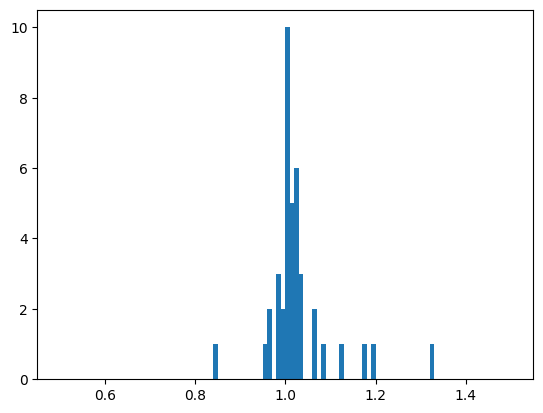

In [10]:
# plot ratio of eta of last copy of quark to the eta of the quark
vbf_quark_last_eta=ak.flatten(genparts_flat[vbf_quark_last_idx].eta)
vbf_quark_first_eta=ak.flatten(genparts_flat[vbf_quark_idx].eta)
plt.hist(vbf_quark_last_eta/vbf_quark_first_eta, bins=100, range=(0.5,1.5))


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 40.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
        1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.

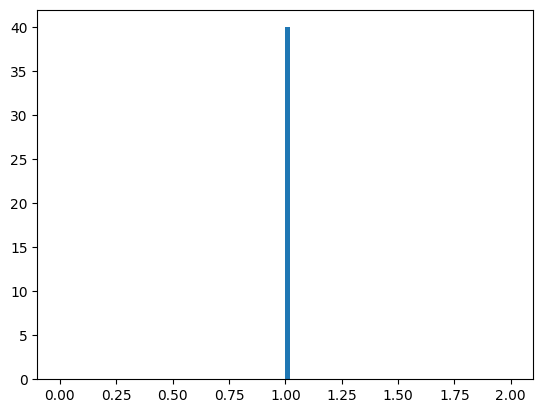

In [11]:
#ratio of pdgId of last copy of quark to the pdgId of the quark
vbf_quark_last_pdgId=ak.flatten(genparts_flat[vbf_quark_last_idx].pdgId)
vbf_quark_first_pdgId=ak.flatten(genparts_flat[vbf_quark_idx].pdgId)
plt.hist(vbf_quark_last_pdgId/vbf_quark_first_pdgId, bins=100, range=(0,2))


# TEST

In [12]:
quark_last=(genpart[isQuark & isHard & (genpart.genPartIdxMother!=-1)& genpart.hasFlags(["isLastCopy"])])
quark_last_flatten=ak.flatten(quark_last)
print(quark_last.pdgId, quark_last.genPartIdxMother, quark_last.index,len(quark_last_flatten))

[[5, 2, 2, -5, 5, -5], [-5, 5, 1, 5, -5, ... 5, -5, 5, -5, -4], [-5, 2, 5, 5, -5, 1]] [[14, 5, 4, 15, 17, 13], [15, 14, 5, 16, ... 23, 20, 21, 5], [24, 4, 29, 28, 27, 5]] [[18, 20, 21, 24, 26, 29], [18, 20, 22, ... 42, 46, 52], [25, 34, 42, 44, 46, 51]] 120


In [13]:
quark_last_mother = (genpart[quark_last.genPartIdxMother])
quark_last_mother_flatten=ak.flatten(quark_last_mother)
print(quark_last_mother.pdgId, quark_last_mother.children.pdgId, quark_last_mother.children.index, len(quark_last_mother_flatten.pdgId))

[[5, 2, 2, -5, 5, -5], [-5, 5, 1, 5, -5, ... 5, -5, 5, -5, -4], [-5, 2, 5, 5, -5, 1]] [[[5, -523, 21, 21, 521], [2], [2], [-5], ... 5], [5], [21, -5, -523, 523], [21, 1]]] [[[18, 19, 22, 23, 25], [20], [21], [24], ... 42], [44], [45, 46, 47, 48], [50, 51]]] 120


In [14]:
# get mother of mother
quark_mother_not_null=quark_last[quark_last_mother.genPartIdxMother!=-1]
quark_mother_not_null_flatten=ak.flatten(quark_mother_not_null)
mother_not_null=quark_last_mother[quark_last_mother.genPartIdxMother!=-1]
mother_not_null_flatten=ak.flatten(mother_not_null)
quark_last_mother_mother = genpart[mother_not_null.genPartIdxMother]
quark_last_mother_mother_flatten=ak.flatten(quark_last_mother_mother)
print(quark_last_mother_mother.pdgId, quark_last_mother_mother.children.pdgId, quark_last_mother_mother.children.index, len(quark_last_mother_mother.pdgId))

[[25, 2, 2, 25, 5, 25], [25, 25, 1, 25, ... 25, 25, 25, -3], [25, 2, 5, 5, 25, 2]] [[[5, -5], [25, 25, 2, 2], [25, 25, 2, 2], ... -521], [5], [5, -5], [25, 25, 2, 1]]] [[[14, 15], [2, 3, 4, 5], [2, 3, 4, 5], ... 29, 43], [28], [26, 27], [2, 3, 4, 5]]] 20


(array([ 0.,  0.,  3.,  1.,  0.,  1.,  0.,  2.,  0.,  0.,  1.,  1.,  2.,
         2.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,
         1.,  1.,  3.,  1.,  1.,  3.,  4.,  2.,  1.,  4.,  4.,  2.,  3.,
         1.,  3.,  4.,  2.,  4.,  5.,  5.,  7.,  7.,  7.,  4., 12.,  1.,
         1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.        , 0.02      , 0.04      , 0.06      , 0.08      ,
        0.1       , 0.12      , 0.14      , 0.16      , 0.18000001,
        0.2       , 0.22      , 0.23999999, 0.25999999, 0.28      ,
        0.30000001, 0.31999999, 0.34      , 0.36000001, 0.38      ,
        0.40000001, 0.41999999, 0.44      , 0.46000001, 0.47999999,
        0.5       , 0.51999998, 0.54000002, 0.56      , 0.57999998,
        0.60000002, 0.62  

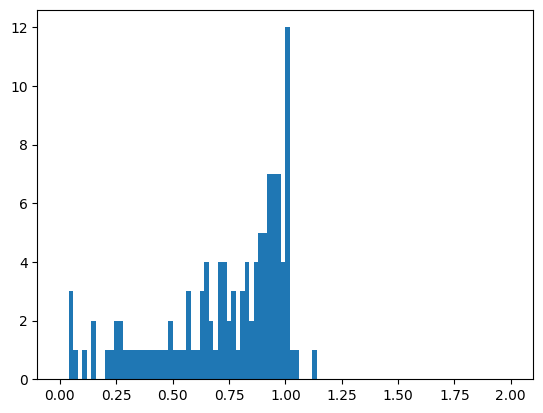

In [15]:
#plot pt ratio of last copy of quark to the pt of the mother
plt.hist(quark_last_flatten.pt/quark_last_mother_flatten.pt, bins=100, range=(0,2))

/work/mmalucch/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(


(array([0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 2., 2., 1., 1., 0., 3.,
        0., 0., 2., 2., 1., 0., 1., 1., 0., 0., 2., 2., 0., 3., 0., 1., 2.,
        0., 1., 0., 3., 0., 2., 3., 0., 1., 0., 0., 3., 3., 0., 1., 4., 1.,
        5., 1., 1., 1., 4., 2., 1., 0., 1., 0., 0., 1., 0., 0., 2., 0., 0.,
        0., 2., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([0.        , 0.02      , 0.04      , 0.06      , 0.08      ,
        0.1       , 0.12      , 0.14      , 0.16      , 0.18000001,
        0.2       , 0.22      , 0.23999999, 0.25999999, 0.28      ,
        0.30000001, 0.31999999, 0.34      , 0.36000001, 0.38      ,
        0.40000001, 0.41999999, 0.44      , 0.46000001, 0.47999999,
        0.5       , 0.51999998, 0.54000002, 0.56      , 0.57999998,
        0.60000002, 0.62      , 0.63999999, 0.66000003, 0.68000001,
        0.69999999, 0.72000003, 0.74000001, 0.75999999, 0.77999997,
      

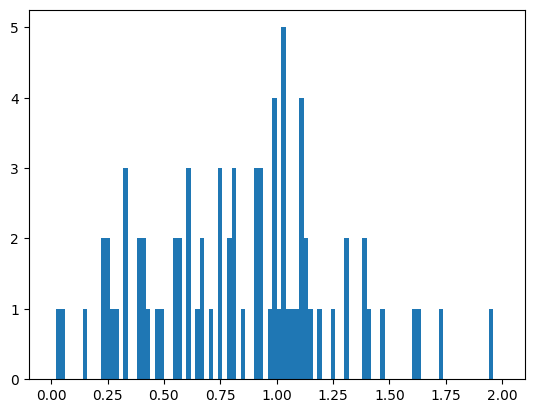

In [16]:
plt.hist(mother_not_null_flatten.pt/quark_last_mother_mother_flatten.pt, bins=100, range=(0,2))

(array([1., 0., 2., 0., 0., 2., 1., 1., 1., 0., 2., 1., 2., 0., 0., 1., 0.,
        0., 1., 4., 2., 1., 0., 4., 2., 1., 0., 2., 2., 2., 0., 2., 3., 2.,
        0., 2., 4., 3., 0., 3., 2., 0., 1., 1., 1., 1., 3., 1., 1., 2., 3.,
        0., 0., 1., 0., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.        , 0.02      , 0.04      , 0.06      , 0.08      ,
        0.1       , 0.12      , 0.14      , 0.16      , 0.18000001,
        0.2       , 0.22      , 0.23999999, 0.25999999, 0.28      ,
        0.30000001, 0.31999999, 0.34      , 0.36000001, 0.38      ,
        0.40000001, 0.41999999, 0.44      , 0.46000001, 0.47999999,
        0.5       , 0.51999998, 0.54000002, 0.56      , 0.57999998,
        0.60000002, 0.62      , 0.63999999, 0.66000003, 0.68000001,
        0.69999999, 0.72000003, 0.74000001, 0.75999999, 0.77999997,
      

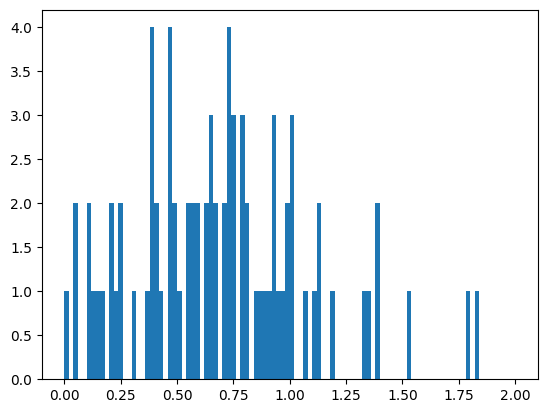

In [17]:
plt.hist(quark_mother_not_null_flatten.pt/quark_last_mother_mother_flatten.pt, bins=100, range=(0,2))

# check if it can happen that multiple children of a particle have the same pdgId has the parent

In [18]:
isQuark = abs(genpart.pdgId) < 7
isHard = genpart.hasFlags(["fromHardProcess"])

quarks = genpart[isQuark & isHard]

quarks = quarks[quarks.genPartIdxMother!=-1]

quarks_mother = genpart[quarks.genPartIdxMother]
quarks_mother_children = quarks_mother.children
quarks_mother_children_isH = ak.sum((quarks_mother_children.pdgId == 25), axis=-1)==2
vbf_quarks = quarks[quarks_mother_children_isH]

print("vbf_quarks children", vbf_quarks.children.pdgId)


children_pdgId = genpart.children.pdgId
parent_pdgId = genpart.pdgId

print(parent_pdgId)
print(children_pdgId)

for event in range(len(vbf_quarks)):
    # for i in range(len(vbf_quarks[event])):
    for i in vbf_quarks[event].index:
        if (
            # True
            ak.sum(parent_pdgId[event][i] == children_pdgId[event][i]) > 1
            and not ak.any(children_pdgId[event][i] == 25)
            and ak.sum(genpart[event][i].children.hasFlags(["fromHardProcess"])) > 1
        ):
            print("Event", event, "Particle", i)
            print("Parent pdg", parent_pdgId[event][i])
            print("Children pdg", children_pdgId[event][i])
            print("chilren index", genpart[event][i].children.index)
            print("children pt", genpart[event][i].children.pt)
            # print("children is last copy", genpart[event][i].children.hasFlags(["isLastCopy"]))
            print(
                "children from hard",
                genpart[event][i].children.hasFlags(["fromHardProcess"]),
            )
            print(
                "children is hard",
                genpart[event][i].children.hasFlags(["isHardProcess"]),
            )
            print(
                "children is prompt", genpart[event][i].children.hasFlags(["isPrompt"])
            )

            print("parent index", genpart[event][i].index)
            print("childre mother index", genpart[event][i].children.genPartIdxMother)

vbf_quarks children [[[2], [2]], [[2], [1]], ... [[1, -423, 2, 21, 21, 21, 111, 111, 111], [21, 1]]]
[[2, 2, 25, 25, 2, 2, 25, 25, 25, 25, ... 421, 431, 111, -11, 12, 221, 22, 22, 22]]
[[[25, 25, 2, 2], [], [25], [25], [2], ... [22], [], [], [22, 22], [], [], []]]
